# Module 2: Plug-and-play (PnP)-ADMM

In the PnP variant of the ADMM algorithm, we replace the proximal operator in the 𝑣-update step with an off-the-shelf image denoiser 𝐷. We will use a pre-trained deep model (based on a U-net architecture, available at https://drive.google.com/ file/d/1FFuauq-PUjY_kG3iiiHfDpHcG4Srl8mQ/view?usp=sharing) for this pur- pose. Use the same U-net implementation as available in https://github.com/ facebookresearch/fastMRI/blob/main/fastmri/models/unet.py and load the pre-trained model using the following lines of code:

This section is aiming recover a clean image (x) from some measurements (y), which is an inverse problem. Previously in medical imaging, I have tried iterative reconstruction techniques, here, I am using the smart optimisation algorithm called ADMM, with a pretrained model (PnP). 

Find a clean image (x) that both matches the observed data (data fidelity term) and looks like a natural image (a prior knowledge that enforces image realism). x and v are separate terms to be solved (but they are both essentially) both the potential images, as it is easier to solve data fidelity term and regulariser term separately. 

The PnP model is essentially outputting the regulariser term, estimating v updates. 

ADMM solves the entire optimization problem by alternating between estimating the best x (based on the data fidelity term) and the best v (based on the regularizer/prior), while encouraging them to agree via the u update.

In [16]:
from unet import Unet
import torch
from skimage import io
import numpy as np
import torch.nn as nn
from torchvision.io import read_image
from torchvision.transforms.functional import convert_image_dtype
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from PIL import Image
from tqdm import tqdm
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
model = Unet(3, 3, chans=64).to(device)
model.load_state_dict(torch.load('denoiser.pth', map_location=device))
model.eval()
# put it in evaluation mode

Unet(
  (down_sample_layers): ModuleList(
    (0): ConvBlock(
      (layers): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Dropout2d(p=0.0, inplace=False)
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (5): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (6): LeakyReLU(negative_slope=0.2, inplace=True)
        (7): Dropout2d(p=0.0, inplace=False)
      )
    )
    (1): ConvBlock(
      (layers): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Dropou


You may use one of the butterfly images from Module 1 as the ground-truth for the ex- ercises in this module, to simulate the image degradation that happened to the entomologist.

The PnP-ADMM algorithm is summarized in the following: initialise + iterate until convergence

The 𝑥-update step is implemented by solving the linear system 𝐶𝑥 = 𝑑 using the conjugate- gradient(CG)method,where𝐶:=𝐴⊤𝐴+𝜂𝐼and𝑑=𝐴⊤𝑦+𝜂(𝑣−𝑢). Thecodefor implementing CG is given below.

In [4]:
def conjugate_gradient(A, b, x0, max_iter, tol): 
    """
    CG for solving Ax=b.
    Here, the argument A is a function that returns Ax 
    """
    x = x0
    r = b-A(x)
    d=r
    for _ in range(max_iter):
        z = A(d)
        rr = torch.sum(r**2)
        alpha = rr/torch.sum(d*z)
        x += alpha*d
        r -= alpha*z
        if torch.norm(r)/torch.norm(b) < tol: 
            break
        beta = torch.sum(r**2)/rr
        d = r + beta*d
    return x

In [5]:
def conv2d_block(kernel, channels, p, device, stride=1):
    """
    Returns nn.Conv2d and nn.ConvTranspose2d modules from 2D kernel, such that
    nn.ConvTranspose2d is the adjoint operator of nn.Conv2d
    Arg:
    kernel: 2D kernel, p x p is the kernel size
    channels: number of image channels
    """
    kernel_size = kernel.shape
    kernel = kernel/kernel.sum()
    kernel = kernel.repeat(channels, 1, 1, 1)
    filter = nn.Conv2d(
    in_channels=channels, out_channels=channels,
    kernel_size=kernel_size, groups=channels, bias=False, stride=stride,
    padding=p//2
    )
    filter.weight.data = kernel
    filter.weight.requires_grad = False
    filter_adjoint = nn.ConvTranspose2d(
    in_channels=channels, out_channels=channels,
    kernel_size=kernel_size, groups=channels, bias=False, stride=stride,
    padding=p//2,
    )
    filter_adjoint.weight.data = kernel
    filter_adjoint.weight.requires_grad = False
    return filter.to(device), filter_adjoint.to(device)

## Excercise 2.1: Deblurring

CODE logic: 

This line : u = u + (x - v), pushes x and v to be the same. I start out with a random x and random v. x being the reconstructed image, and v being the denoised image using unet. the difference being x is based on the data, and v is based on how natural images look like when the unet was trained.

The x update is trying to fit the blurry image y, with the denosied image v. to do this, i use the conjugate gradient.

x update can be reshaped into Cx = b. This is a linear equation, trying to solve for x (reconstructed image), given that the variables are C(data fidelty term to match image y, and regularisation to stay close to denoised guess v)

In [6]:
### FIRST, read in image as torch object
#image is read in as a torch object with Channels,Height,Width
#I need it in (Batchsize,Channels,Height,Width) to be compatible with forward operation.
#Add batch size
# the image is loaded in uint8, which is an 8 bit integer with values 0 to 255. uint8 is for storage, not computation. 0-255 is not good for neural nets, i want it normalised.


ground_truth_image = read_image("./data/Image_6.jpg").unsqueeze(0)
ground_truth_image = convert_image_dtype(ground_truth_image, dtype=torch.float32)
ground_truth_image = ground_truth_image.to(device)

In [7]:
def make_kernel(kernel_size=3):
    """

    A function to make a simple averaging kernel. The kernel size can change.

    Returns:
        kernel
    """
    kernel = torch.ones((kernel_size, kernel_size), dtype=torch.float32)
    kernel /= kernel_size ** 2
    return kernel

def mse(blur_img, recon_img):
    """
    A function to take two torch images and calculating the mse.

    Args:
        blur_img (_type_): blurred image
        recon_img (_type_): reconstructed image

    Returns:
        torch mse, please call object.item() to turn it into a float.
    """
    mse_val = torch.mean((blur_img - recon_img) ** 2)
    mse_float = mse_val.item() #turn from tensor to float
    final_mse = np.round(mse_float,5)
    return final_mse

# x is the sharp image, A is the forward operator (blur), and y is the blurred image.
""""
def torch_to_numpy(img):
    image = img.squeeze(0).cpu()
    numpy_image = image.permute(1, 2, 0).tolist()
    return numpy_image 

def numpy_to_torch(img):
    image = img.squeeze(0).cpu()
    # Manually convert to nested Python list format [H][W][C]
    torch_image = image.permute(1, 2, 0).tolist()  # shape: [H, W, 3]
    return torch_image

"""

def numpy_to_torch(img):
    # img should be numpy array [H, W, C]
    torch_image = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float()
    return torch_image

def torch_to_numpy(img):
    # img should be [1, C, H, W]
    numpy_image = img.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    return numpy_image


In [8]:
def pnp_admm(y,eta,A,AT,tolerance,iter,model):
    """
    Plug-and-Play ADMM for image reconstruction using a learned denoiser.

    This function solves an inverse problem using the Plug-and-Play Alternating Direction 
    Method of Multipliers (PnP-ADMM) framework. It alternates between reconstructing an 
    image to match measured data and denoising it using a pretrained model.
    
    Parameters:
    
        y (torch.Tensor): Observed measurement (e.g., blurred or masked image).
        
        eta (float): Regularization parameter that balances data fidelity and prior.
        
        A (function): Forward operator that simulates the degradation (e.g., blur or mask).
        
        AT (function): Adjoint (transpose) of the forward operator A.
        
        tolerance (float): Tolerance for the conjugate gradient solver.
        
        iter (int) :  Number of ADMM iterations.
        
        model (torch.nn.Module): Pretrained denoising model (e.g., DnCNN or U-Net).
    
    Returns:
        reconstructed image (torch.Tensor): Reconstructed image after ADMM iterations, clamped to [0, 1].
        
    """
### 1.  Initialise the variable:

    #This is the best guess of the image (filled with zeros, with the blurred image dimensions)
    x = torch.zeros_like(y)

    # v is a denosied version of x + u, dynamically updated each iteration.
    v = torch.zeros_like(y)

    # This is the dual variable. This tracks the difference between the reconstructed image x and the denoised image v.
    u = torch.zeros_like(y)
    
### 2. Calculate the x update:
    
    # first part of the x-update
    def C(x):
        return AT(A(x)) + eta * x

    for iteration in tqdm(range(iter),desc="Iteration number:"):
        # second part of the x-update
        b = AT(y) + eta * (v - u)
        
        # Solve x in Cx = b using the conjugate gradient
        x = conjugate_gradient(C, b, x, iter, tolerance)
        
### 3. Calculate the v update (make a denoised reconstruction)
        with torch.no_grad():
            denoiser_input = torch.clamp(x + u, 0, 1)
            v = model(denoiser_input)
### 4. Calculate the u update (make the denoised reconstruction, and data-driven reconstruction match)
        u = u + (x - v)
    return torch.clamp(x, 0.0, 1.0)




trying kernel size 7...


Iteration number::   0%|          | 0/20 [00:00<?, ?it/s]

Iteration number:: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


trying kernel size 13...


Iteration number:: 100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


trying kernel size 17...


Iteration number:: 100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


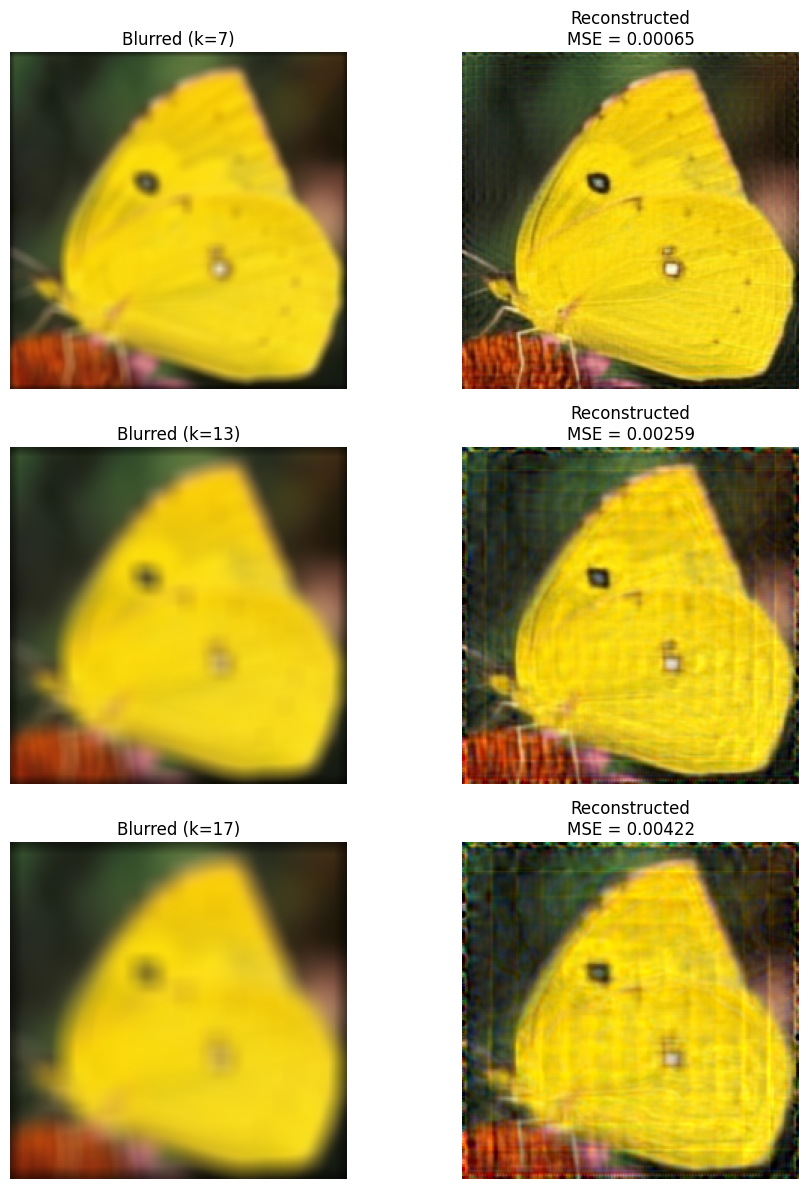

In [12]:
iter = 20 #iterative reconstruction for 20 iterations.
eta = 0.0001 #this is the learn rate
tolerance = 0.0001 #tolerance for how different the linear equation can deviate from
kernel_size = [7,13,17] # kernel sizes to try
folder = "./results_for_plotting" # i will save everything in here
fig, axs = plt.subplots(3, 2, figsize=(10, 12))

mse_dict = {}

for idx, k in enumerate(kernel_size): 
    print(f"trying kernel size {k}...")
    
#### Make the blurred image

    #First, I make the kernel
    blur_kernel = make_kernel(kernel_size=k)
    #Then, with the specific kernel size, I make the forward and reverse oeprator 
    A, AT = conv2d_block(blur_kernel, channels=3, p=k, device=device)
    #I make a blurred version of the butterfly image. This is the image i want to deblur.
    y = A(ground_truth_image) 

#### Define the update variables in PnP-ADMM
    x = pnp_admm(y=y,eta=0.0001,A=A,AT=AT,tolerance=0.0001,iter=20,model=model)
    x = torch.clamp(x, 0.0, 1.0)  # Ensure final output is in [0,1]

#### Calculate the mean square error
    mse_val = mse(ground_truth_image,x)
    
#### View the cleaned/blurry images
    recon = torch_to_numpy(x)
    blur = torch_to_numpy(y)

    # Show blurred
    axs[idx, 0].imshow(blur)
    axs[idx, 0].set_title(f"Blurred (k={k})")
    axs[idx, 0].axis('off')

    # Show reconstructed
    axs[idx, 1].imshow(recon)
    axs[idx, 1].set_title(f"Reconstructed\nMSE = {mse_val}")
    axs[idx, 1].axis('off')
    
    torch.save(x.cpu(), f"{folder}/2.1.1_deblur_k{k}.pt")
    mse_dict[f"2.1.1_deblur_k{k}"] = float(mse_val)
    
    if k == 13:
        save_path = f"{folder}/reconstructed_k13.png"
        fig.savefig(save_path)  # Save the whole figure

plt.tight_layout()
plt.show()

## Excercise 2.1.2: Adding gaussian noise to blurred image

Iteration number:: 100%|██████████| 20/20 [00:58<00:00,  2.94s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.027087282..1.0149728].


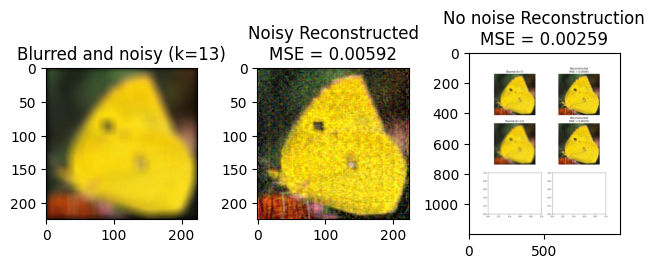

In [14]:
kernel_size = 13

#### Make the blurred image 

#First, I make the kernel
blur_kernel = make_kernel(kernel_size=k)
#Then, with the specific kernel size, I make the forward and reverse oeprator 
A, AT = conv2d_block(blur_kernel, channels=3, p=k, device=device)
#I make a blurred version of the butterfly image. This is the image i want to deblur.
y = A(ground_truth_image) 

sigma = 0.01  # standard deviation of Gaussian noise

# Ensure y is on the correct device and dtype (float32)
noise = sigma * torch.randn_like(y)  # same shape, mean=0, std=1 scaled by sigma
y_noisy = y + noise

#### Make the blurred image a torch object.

x_noisy = pnp_admm(y=y_noisy,eta=0.0001,A=A,AT=AT,tolerance=0.0001,iter=20,model=model)
x_noisy = torch.clamp(x_noisy, 0.0, 1.0)  # Ensure final output is in [0,1]

#### Calculate the mean square error
noisy_mse = mse(ground_truth_image,x_noisy)

#reconstruction from no noise (k=13)
nonoise_k13 = Image.open("./results_for_plotting/reconstructed_k13.png")
noisy_recon = torch_to_numpy(x_noisy)
noisy_blur = torch_to_numpy(y_noisy)

torch.save(x_noisy.cpu(), f"{folder}/2.1.2_noisy_deblur_k13.pt")
mse_dict["2.1.2_noisy_deblur_k13"] = float(noisy_mse)
    
# Show blurred

fig, ax = plt.subplots(1,3)

ax[0].imshow(noisy_blur)
ax[0].set_title(f"Blurred and noisy (k=13)")
ax[1].imshow(noisy_recon)
ax[1].set_title(f"Noisy Reconstructed\nMSE = {noisy_mse}")
ax[2].imshow(nonoise_k13)
ax[2].set_title(f"No noise Reconstruction\nMSE = {mse_dict['2.1.1_deblur_k13']:.5f}")

plt.tight_layout()
plt.show()

### Excercise 2.2: Impainting

Using the same image, multiply it by a mask to remove some of the pixels.
Using image 6, remove the pixels by multiplying by the mask. the mask is a torch mask of random values in random positions between 0 - 1, with a normal distribution. so if i say all the values below 0.4 to be 0, then it will set 40% of random locations to 0. 


### Excercise 2.2.1: MSE for pnp-admm

Here, I have rewritten a simpler version of pnp_admm function, because since it is a diagonal matrix, I don't need an iterative solver, and I can solve it in closed form.

but here i am solving it using iterative anyways.

Using device: cpu

Running with 40% pixels missing...


Iteration number:: 100%|██████████| 20/20 [00:32<00:00,  1.65s/it]


MSE: 0.1281

Running with 60% pixels missing...


Iteration number:: 100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


MSE: 0.1720

Running with 80% pixels missing...


Iteration number:: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


MSE: 0.2035


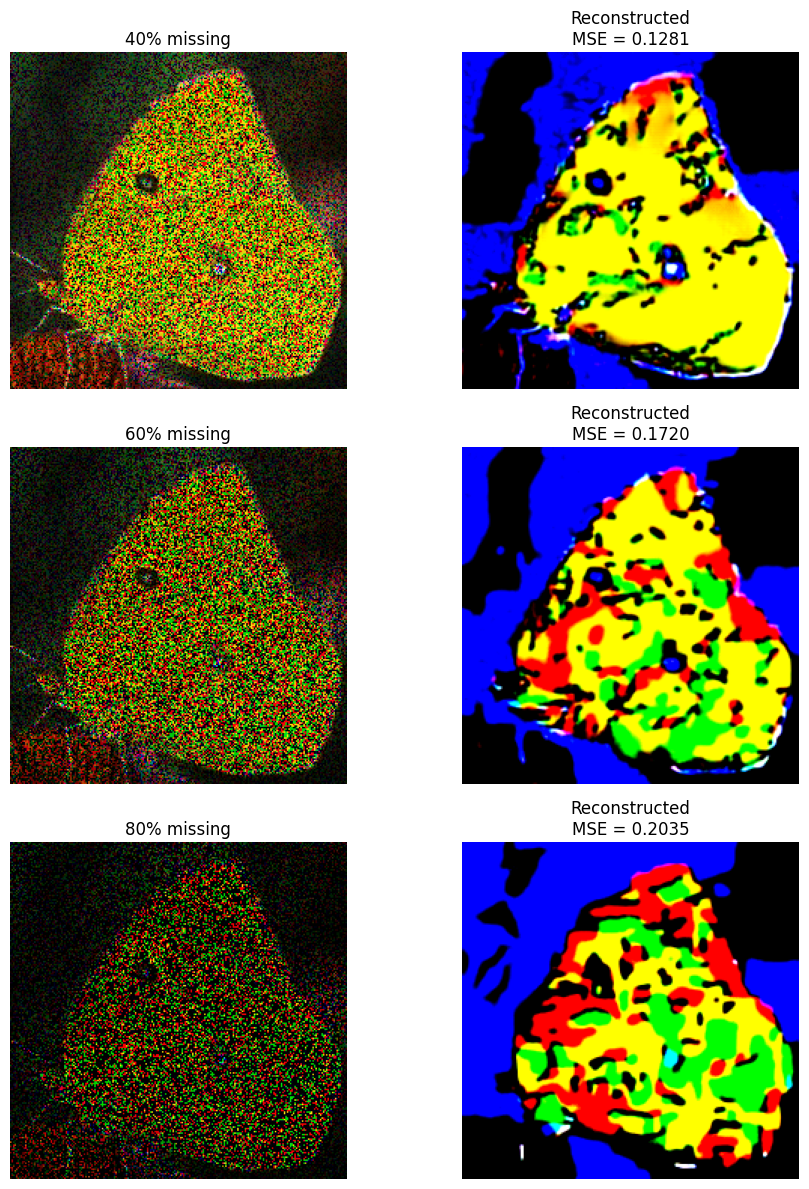

In [17]:
#plotting impainting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
ground_truth_image = read_image("./data/Image_6.jpg")
ground_truth_image = convert_image_dtype(ground_truth_image, dtype=torch.float32)  # Normalize to [0,1]
ground_truth_image = ground_truth_image.unsqueeze(0).to(device)  # Shape: [1, C, H, W]


def generate_mask(keep_ratio, shape):
    return (torch.rand(*shape, device=device) < keep_ratio).float()


def get_inpainting_ops(mask):
    def A(x): return x * mask
    return A, A 

missing_ratios = [0.4, 0.6, 0.8]
fig, axs = plt.subplots(len(missing_ratios), 2, figsize=(10, 12))

for idx, miss in enumerate(missing_ratios):
    keep = 1 - miss
    print(f"\nRunning with {int(miss*100)}% pixels missing...")

    mask = generate_mask(keep_ratio=keep, shape=ground_truth_image.shape)

    A, AT = get_inpainting_ops(mask)

    y = A(ground_truth_image)

    recon = pnp_admm(
        y=y,
        eta=1,
        A=A,
        AT=AT,
        tolerance=1e-4,
        iter=20,
        model=model
    )

    mse_val = mse(ground_truth_image, recon)
    print(f"MSE: {mse_val:.4f}")

    if miss == 0.6:
        torch.save(mask, os.path.join(folder, "60_mask.pt"))
        save_image(recon.cpu(), os.path.join(folder, "60_recon.png"))
        
    #save metrics and reconstructions for module 3
    torch.save(recon.cpu(), f"{folder}/2.2.1_impainting_admm_{miss}.pt")
    mse_dict[f"2.2.1_impainting_admm_{miss}"] = float(mse_val)

    # Plotting
    axs[idx, 0].imshow(torch_to_numpy(y))
    axs[idx, 0].set_title(f"{int(miss * 100)}% missing")
    axs[idx, 0].axis("off")

    axs[idx, 1].imshow(torch_to_numpy(recon))
    axs[idx, 1].set_title(f"Reconstructed\nMSE = {mse_val:.4f}")
    axs[idx, 1].axis("off")

plt.tight_layout()
plt.show()

    

so ADMM and RED both replace the regulariser (usually total variation, like the magnitude of the weights) with a neural network denoiser. this denoiser is different between the two, as ADMM alternates between updating the x image (reconstructed image) and the v image (denoised version of x + u), but RED is gradient descent, and only updates image x in consecutive steps.

### Excercise 2.2.2: pnp-ADMM vs pnp-RED

In [18]:
def pnp_red(y, A, AT, iter, model, step_size=0.1, eta=1.0):
    """
    Implements the PnP-RED gradient descent algorithm.

    Args:
        y: Corrupted image (with missing pixels).
        A: Forward operator.
        AT: Transpose of A.
        iter: Number of iterations.
        model: Denoising model (D(x)).
        step_size: Regularisation strength.
        eta: Gradient desscent Step size.

    Returns:
        Reconstructed image x.
    """
    # Initializing x (e.g., zero image with same shape as y)
    x = torch.zeros_like(y)
    
    for i in tqdm(range(iter),desc="iteration"):
        Ax = A(x)
        residual = AT(Ax - y)  # gradient of data term
        denoised = model(x)    # D(x)
        grad_J = residual + step_size * (x - denoised)

        # Gradient descent step
        x = x - eta * grad_J
    return torch.clamp(x, 0.0, 1.0) 

iteration: 100%|██████████| 20/20 [00:29<00:00,  1.45s/it]


<function matplotlib.pyplot.show(close=None, block=None)>

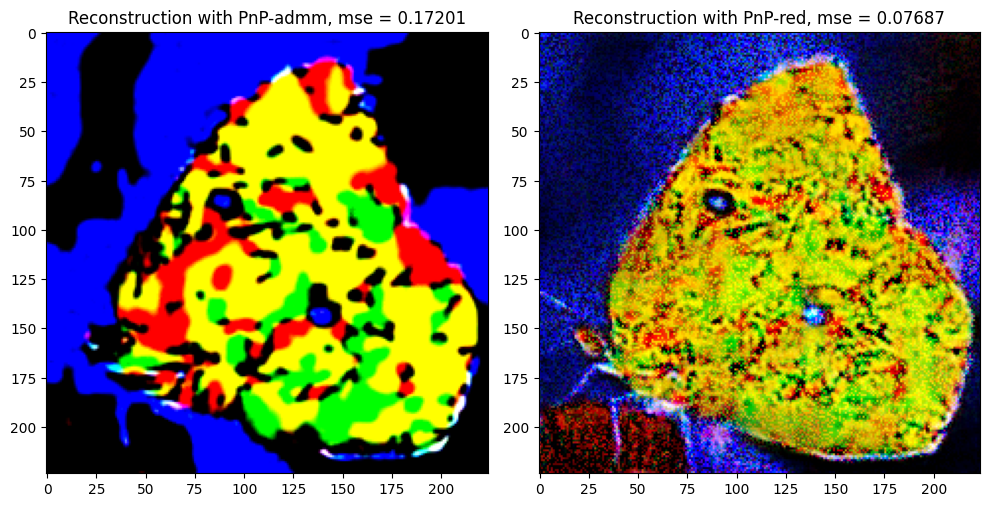

In [20]:
loaded_mask = torch.load(f"./{folder}/60_mask.pt")
loaded_image = read_image(f"./{folder}/60_recon.png")

def forward(x, mask):
    return x * mask

A = lambda x: forward(x, loaded_mask)
AT = A  

start_img = A(ground_truth_image)

with torch.no_grad():
    recon = pnp_red(
        y=start_img,
        A=A,
        AT=AT,
        iter=20,
        model=model,
        step_size=0.1,
        eta=1.0
    )

mse_val = mse(ground_truth_image,recon)

#save metrics and reconstructions for module 3
torch.save(recon.cpu(), f"{folder}/2.2.2_impainting_red_0.6.pt")
mse_dict[f"2.2.2_impainting_red_0.6"] = float(mse_val)

fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(torch_to_numpy(loaded_image))
ax[0].set_title(f"Reconstruction with PnP-admm, mse = {mse_dict['2.2.1_impainting_admm_0.6']:.5f}")

ax[1].imshow(torch_to_numpy(recon))
ax[1].set_title(f"Reconstruction with PnP-red, mse = {mse_val}")

plt.tight_layout()
plt.show


In [21]:
print(mse_dict)

{'2.1.1_deblur_k7': 0.00065, '2.1.1_deblur_k13': 0.00259, '2.1.1_deblur_k17': 0.00422, '2.1.2_noisy_deblur_k13': 0.00664, '2.2.2_impainting_red_0.6': 0.07962, '2.2.1_impainting_admm_0.4': 0.12641, '2.2.1_impainting_admm_0.6': 0.17277, '2.2.1_impainting_admm_0.8': 0.20384}


In [22]:
torch.save(mse_dict, os.path.join(folder, "mse_values.pt"))

### Excercise 2.3: Does number of iterations affect the pnp_admm mse for both impainting and blurred reconstructions?

In [15]:
#deblurring iterations

iterations = list(range(1, 21)) + [40,60]
blur_kernels = [7, 17]
inpaint_ratios = [0.4, 0.8]
eta_blur = 0.0001
eta_inpaint = 1
tolerance = 1e-4

mse_logs_deblur = {}
mse_logs_inpaint_admm = {} 
mse_logs_inpaint_red = {}  

for k in blur_kernels:
    kernel = make_kernel(k)
    A_blur, AT_blur = conv2d_block(kernel, channels=3, p=k, device=device)
    y_blur = A_blur(ground_truth_image)
    mse_list = []
    for it in iterations:
        recon = pnp_admm(
            y=y_blur,
            eta=eta_blur,
            A=A_blur,
            AT=AT_blur,
            tolerance=tolerance,
            iter=it,
            model=model
        )
        mse_val = mse(ground_truth_image, recon).item()
        mse_list.append(mse_val)
    mse_logs_deblur[k] = mse_list


Iteration number:: 100%|██████████| 60/60 [03:54<00:00,  3.90s/it]


In [16]:
#impainting iterations
for miss_ratio in inpaint_ratios:
    keep_ratio = 1 - miss_ratio

    mask = (torch.rand_like(ground_truth_image) < keep_ratio).float()

    A_inpaint = lambda x: x * mask
    AT_inpaint = A_inpaint

    y_inpaint = A_inpaint(ground_truth_image)

    mse_admm_list = []
    for it in iterations:
        recon = pnp_admm(
            y=y_inpaint,
            eta=eta_inpaint,
            A=A_inpaint,
            AT=AT_inpaint,
            tolerance=tolerance,
            iter=it,
            model=model
        )
        mse_val = mse(ground_truth_image, recon).item()
        mse_admm_list.append(mse_val)
    mse_logs_inpaint_admm[miss_ratio] = mse_admm_list

    mse_red_list = []
    for it in iterations:
        recon = pnp_red(
            y=y_inpaint,
            A=A_inpaint,
            AT=AT_inpaint,
            iter=it,
            model=model,
            step_size=0.1,
            eta=1.0
        )
        mse_val = mse(ground_truth_image, recon).item()
        mse_red_list.append(mse_val)
    mse_logs_inpaint_red[miss_ratio] = mse_red_list



Iteration number::   0%|          | 0/1 [00:00<?, ?it/s]

iteration: 100%|██████████| 60/60 [01:58<00:00,  1.98s/it]


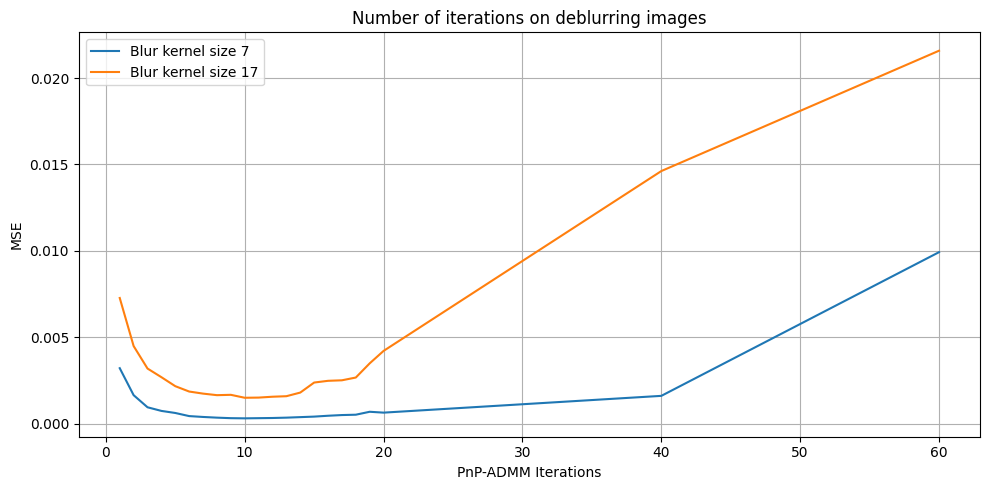

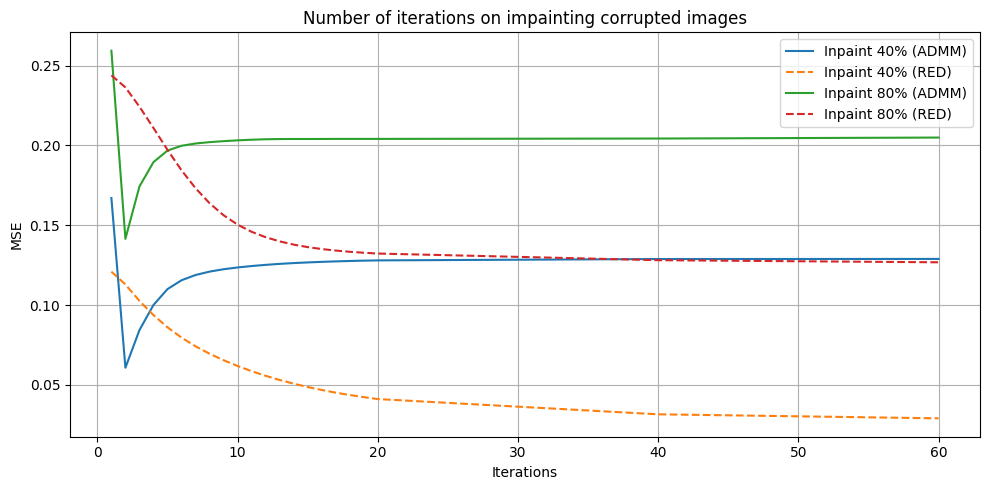

In [21]:
#plotting
plt.figure(figsize=(10, 5))
for k in blur_kernels:
    plt.plot(iterations, mse_logs_deblur[k], label=f"Blur kernel size {k}")
plt.xlabel("PnP-ADMM Iterations")
plt.ylabel("MSE")
plt.title("Number of iterations on deblurring images")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
for r in inpaint_ratios:
    plt.plot(iterations, mse_logs_inpaint_admm[r], label=f"Inpaint {int(r*100)}% (ADMM)")
    plt.plot(iterations, mse_logs_inpaint_red[r], linestyle="--", label=f"Inpaint {int(r*100)}% (RED)")
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title("Number of iterations on impainting corrupted images")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()